In [27]:
# If not running on AWS instance,
# keep this running in the command line:
# ssh -NL 12345:localhost:27017 myaws &
# To kill:
# use ps | grep "ssh -NL" to find jobID, then
# kill [jobID]

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from sklearn.model_selection import train_test_split
import time
import re
import json
from pymongo import MongoClient
import warnings
import logging
import gc
import pickle

%matplotlib inline
pd.options.display.max_columns = 50

In [33]:
def to_num(x):
    if x == "":
        return np.nan
    else:
        return float(x)

In [34]:
mongoClient = MongoClient(port = 12345)
bookiddb = mongoClient.bookiddb2
bookidColl = bookiddb.bookidColl

bookdb = mongoClient.bookdb2
bookColl = bookdb.bookColl

reviewdb = mongoClient.reviewdb2
reviewColl = reviewdb.reviewColl

In [35]:
c = bookidColl.find()
bookid_li = list(c)[0]['book_li']

c = bookColl.find()
book_df = pd.DataFrame(list(c))

c = reviewColl.find()
review_df = pd.DataFrame(list(c))

### cleaning

In [36]:
book_df['avg_rating'] = book_df['avg_rating'].astype(float)
book_df['bookid'] = book_df['bookid'].astype(int)
book_df['n_ratings'] = book_df['n_ratings'].astype(int)
book_df['n_text_reviews'] = book_df['n_text_reviews'].astype(int)
book_df['page_ct'] = book_df['page_ct'].map(to_num)
book_df['pub_yr'] = book_df['pub_yr'].map(to_num)
book_df['title'] = book_df['title'].map(lambda x: re.sub("Reviews", "", x).strip(" "))
book_df['desc'] = book_df['desc'].map(lambda x: re.sub(r"\n|\t", " ", x).strip(" "))
book_df = book_df.drop(['_id', 'leng'], axis = 1) # TODO exclude non-Engilsh?
book_df.columns = ['bk_author', 'bk_avg_rating', 'bookid', "bk_desc", 'bk_n_ratings', 'bk_n_text_reviews', \
                   'bk_page_ct', 'bk_pub_yr', 'bk_title']

In [37]:
review_df['bookid'] = review_df['bookid'].astype(int)
review_df['like_ct'] = review_df['like_ct'].astype(int)
review_df['rating'] = review_df['rating'].astype(int)
review_df['userid'] = review_df['userid'].map(lambda x: int(re.sub(r"[^0-9]", "", x).strip(" ")))
review_df['review'] = review_df['review'].map(lambda x: re.sub(r"\n|\t", " ", x).strip(" "))
del review_df['_id']

In [38]:
review_df['review_date'] = pd.to_datetime(review_df['review_yr'])
review_df['review_yr_num'] = review_df['review_date'].dt.year
review_df['review_mon_num'] = review_df['review_date'].dt.month
review_df['review_wday_num'] = review_df['review_date'].map(lambda x: x.isoweekday())
del review_df['review_yr']

In [39]:
first_review = pd.DataFrame(review_df.groupby('bookid').min()['review_date'])
first_review.reset_index(inplace = True)
first_review.columns = ['bookid', 'first_review']
first_review.tail(1)
review_df = review_df.merge(first_review, on = 'bookid')
review_df['since_first_review'] = (review_df['review_date'] - review_df['first_review']).astype('timedelta64[D]')
del review_df['first_review']

In [40]:
review_df.columns = ['bookid', 'review_like_ct', 'review_rating', 'review_desc', 'userid', \
                     'review_date', 'review_yr', 'review_mon', 'review_wday_num', 'review_d_since_1streview']

In [41]:
print(review_df.shape)
book_review = review_df.merge(book_df, how = "inner", on = "bookid")
print(book_review.shape)

(21278, 10)
(21278, 18)


In [42]:
book_review['bookid'].drop_duplicates().shape

(937,)

### add features

In [12]:
user_tot_reviews = pd.DataFrame(book_review['userid'].value_counts())
user_tot_reviews.reset_index(inplace = True)
user_tot_reviews.columns = ['userid', 'user_tot_reviews']
book_review = book_review.merge(user_tot_reviews, how = "left", on = "userid")

In [13]:
dups = pd.concat(g for _, g in book_review.groupby(['bookid', 'userid']) if len(g) > 1)
dups = dups[['bookid', 'userid']].drop_duplicates()
dups['dup_ind'] = 1
book_review = book_review.merge(dups, how = "left", on = ['bookid', 'userid'])
book_review['dup_ind'] = book_review['dup_ind'].fillna(0)

In [14]:
book_review['bk_desc_len'] = book_review['bk_desc'].map(len)
book_review['review_desc_len'] = book_review['review_desc'].map(len)

In [ ]:
# TODO else? transform data?

### overall check

In [ ]:
book_review.tail(1)

In [ ]:
book_review.info()

### check dups

In [ ]:
bookid_li[:10]

In [ ]:
print(len(bookid_li))
bookid_set = set(bookid_li)
print(len(bookid_set))

In [ ]:
book_df.tail(1)

In [ ]:
print(book_df.shape)
book_df_dedupall = book_df.drop_duplicates()
print(book_df_dedupall.shape)
book_df_dedup = book_df.drop_duplicates(subset = ['bookid'])
print(book_df_dedup.shape)

In [ ]:
review_df.tail(1)

In [ ]:
print(review_df.shape)
review_df_dedupall = review_df.drop_duplicates()
print(review_df_dedupall.shape)
review_df_dedup = review_df.drop_duplicates(subset = ['bookid', 'userid'])
print(review_df_dedup.shape, str((1 - review_df_dedup.shape[0] / review_df_dedupall.shape[0]) * 100) + "%")

In [ ]:
dups = pd.concat(g for _, g in review_df.groupby(['bookid', 'userid']) if len(g) > 1)
print(dups.shape)
dups.head(4)

### checking things

In [ ]:
# book_df['leng'].value_counts()

In [ ]:
cond = book_df['bk_author'] == 'Ray Bradbury'
book_df.loc[cond]

In [ ]:
cond = review_df['bookid'] == 23929479
review_df.loc[cond]

In [ ]:
review_ct = pd.DataFrame(review_df['userid'].value_counts())
review_ct.columns = ['review_ct']
review_ct.sort_values('review_ct', ascending = False, inplace = True)
review_ct.head(1)

In [ ]:
num_display = 500
my_yticks = range(num_display, 0, -1)
plt.figure()
plt.barh(my_yticks, review_ct['review_ct'].iloc[:num_display])
plt.yticks(my_yticks, review_ct.index)
plt.show()

In [ ]:
review_ct_per_book = review_df.groupby('bookid').agg('count')[['userid']]
review_ct_per_book.reset_index(inplace = True)
review_ct_per_book.columns = ['bookid', 'review_ct_per_book']
review_ct_per_book.sort_values('review_ct_per_book', ascending = False, inplace = True)
review_ct_per_book.head(1)

In [ ]:
avg_review_ct = review_df.shape[0] / book_df.shape[0]
avg_review_ct

In [ ]:
book_review.tail(1)

### check failed scraping cookie

In [43]:
check_cookie = pd.DataFrame({"order": np.array(range(len(bookid_li))) + 1, "bookid": pd.Series(bookid_li).map(int)})
check_cookie = check_cookie.merge(book_df[['bookid', 'bk_n_text_reviews']], on = 'bookid')

scrape_ct = pd.DataFrame(review_df['bookid'].value_counts())
scrape_ct.reset_index(inplace = True)
scrape_ct.columns = ['bookid', 'scrape_ct']
check_cookie = check_cookie.merge(scrape_ct, on = 'bookid')
check_cookie.tail(1)

,bookid,order,bk_n_text_reviews,scrape_ct
936,17261174,2148,642,22


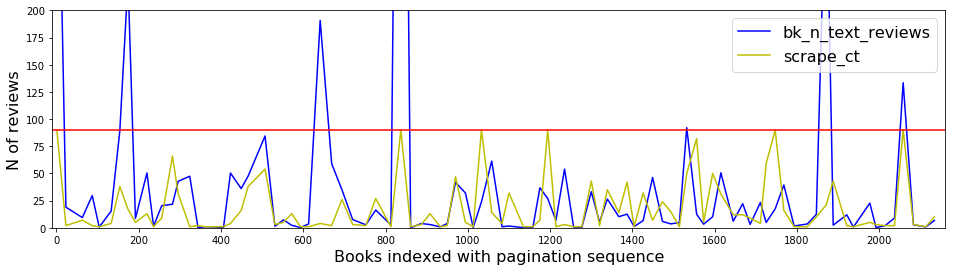

In [47]:
plt.figure(figsize = (16, 4))
sample = range(0, check_cookie.shape[0], 10)
plt.plot(check_cookie['order'].iloc[sample], check_cookie['bk_n_text_reviews'].iloc[sample] / 100, "b-")
plt.plot(check_cookie['order'].iloc[sample], check_cookie['scrape_ct'].iloc[sample], "y-")
plt.axhline(90, color = 'red')
plt.ylim([0, 200])
# plt.yticks(list(range(0, 91, 10)))
plt.xlim([-10, 2160])
plt.xticks(list(range(0, 2160, 200)))
plt.ylabel("N of reviews", fontsize = 16)
plt.xlabel("Books indexed with pagination sequence", fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

### check language

In [ ]:
# book_review['leng'].value_counts() 

In [ ]:
# cond = book_review['leng'] == 'spa'
# book_review.loc[cond, 'title'].value_counts()

In [ ]:
# cond = book_review['leng'] == 'ind' # Indonesian, but the webpage looks English:(
# book_review.loc[cond]

### check book desc len

In [ ]:
cond = book_review['bk_desc_len'] == 0
n_zero_len = sum(cond)
n = len(book_review['bk_desc_len'])
print(n_zero_len, n, n_zero_len / n * 100)

In [ ]:
book_review[cond].head(1)

In [ ]:
# blank book synopsis seems to be scraping error, but other columns look fine

In [ ]:
plt.figure(figsize = (8, 4))
plt.hist(book_review.loc[~cond, 'bk_desc_len'], bins = 100)
plt.show()

### check review text len

In [ ]:
cond = book_review['review_desc_len'] == 0
n_zero_len = sum(cond)
n = len(book_review['review_desc_len'])
print(n_zero_len, n, n_zero_len / n * 100)

In [ ]:
non0_cond = book_review['review_desc_len'] > 0
new_cond = book_review['review_desc_len'] == min(book_review.loc[non0_cond, 'review_desc_len'])
book_review[new_cond] # someone actually wrote this..

In [ ]:
plt.figure(figsize = (16, 4))
plt.hist(book_review.loc[~cond, 'review_desc_len'], bins = 200)
plt.show()

### holdout split

In [16]:
holdout_ratio = 0.1
holdout_n_rows = round(book_review.shape[0] * holdout_ratio)
holdout_n_rows

2128

In [17]:
# TODO don't need this part; I forgot there's user_tot_reviews
review_ct_per_user = pd.DataFrame(book_review.groupby('userid').count()['bookid'])
review_ct_per_user.reset_index(inplace = True)
review_ct_per_user.columns = ['userid', 'ct']
cond = review_ct_per_user['ct'] >= 3
review_ct_per_user = review_ct_per_user.loc[cond]
review_ct_per_user.tail(2)

,userid,ct
11299,59458347,3
11347,63472114,10


In [18]:
n_in_subset = review_ct_per_user.groupby(np.ones(review_ct_per_user.shape[0])).sum(axis = 1)['ct']
subset_ratio = float(round(holdout_n_rows / n_in_subset, 1))
subset_ratio

0.2

In [19]:
cond = book_review['userid'].map(str).str.contains("|".join(review_ct_per_user['userid'].map(str)))
subset = book_review.loc[cond]

In [20]:
# subset.tail(1)
# subset[subset['userid'] == 92508]

In [21]:
_, book_review_holdout = train_test_split(subset, test_size = subset_ratio, random_state = 0)
# book_review_holdout.tail(1)

In [22]:
book_review_holdout = book_review_holdout.copy() # debugging line
book_review_holdout['holdout'] = 1
book_review_train = book_review.merge(book_review_holdout[['bookid', 'userid', 'holdout']], how = "left", \
                                      on = ['bookid', 'userid'])
cond = book_review_train['holdout'] != 1
book_review_train = book_review_train[cond]

In [23]:
del book_review_train['holdout']
book_review_train.reset_index(drop = True, inplace = True)
book_review_train.tail(1)

,bookid,review_like_ct,review_rating,review_desc,userid,review_date,review_yr,review_mon,review_wday_num,review_d_since_1streview,bk_author,bk_avg_rating,bk_desc,bk_n_ratings,bk_n_text_reviews,bk_page_ct,bk_pub_yr,bk_title,user_tot_reviews,dup_ind,bk_desc_len,review_desc_len
19230,17261174,1,5,"Utterly charming, well paced, written and draw...",1722508,2016-09-23,2016,9,5,1177.0,Tony Cliff,3.94,"A little bit Tintin, a little bit Indiana Jone...",5828,642,122.0,2013.0,Delilah Dirk and the Turkish Lieutenant,1,0.0,169,234


In [24]:
del book_review_holdout['holdout']
book_review_holdout.reset_index(drop = True, inplace = True)
book_review_holdout.tail(1)

,bookid,review_like_ct,review_rating,review_desc,userid,review_date,review_yr,review_mon,review_wday_num,review_d_since_1streview,bk_author,bk_avg_rating,bk_desc,bk_n_ratings,bk_n_text_reviews,bk_page_ct,bk_pub_yr,bk_title,user_tot_reviews,dup_ind,bk_desc_len,review_desc_len
2033,6261189,9,5,This book took me totally by suprise! It's dar...,4765786,2011-01-07,2011,1,5,493.0,Stacia Kane,3.64,The world is not the way it was. The dead have...,12776,1541,323.0,2010.0,Unholy Ghosts,3,0.0,802,548


In [25]:
print(book_review_train.shape, book_review_holdout.shape, book_review_holdout.shape[0] / book_review_train.shape[0])

(19231, 22) (2034, 22) 0.10576673079923041


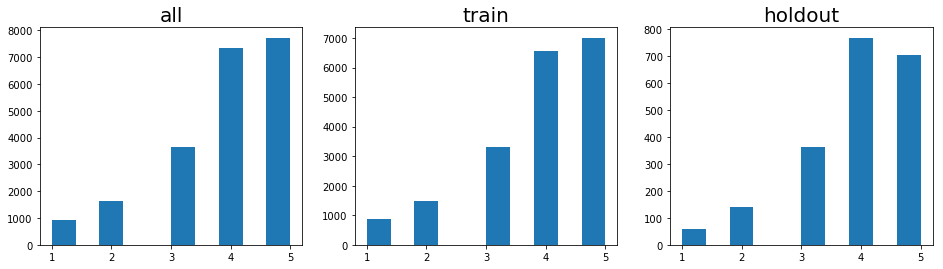

In [35]:
plt.subplots(1, 3, figsize = (16, 4))
plt.subplot(1, 3, 1)
plt.hist(book_review['review_rating'])
plt.title("all", fontsize = 20)
plt.xticks(range(1, 6))

plt.subplot(1, 3, 2)
plt.hist(book_review_train['review_rating'])
plt.title("train", fontsize = 20)
plt.xticks(range(1, 6))

plt.subplot(1, 3, 3)
plt.hist(book_review_holdout['review_rating'])
plt.title("holdout", fontsize = 20)
plt.xticks(range(1, 6))
plt.show()

### pickle

In [15]:
with open('cleaned_data_all.pkl', 'wb') as picklefile:
    pickle.dump(book_review, picklefile)

In [26]:
with open('cleaned_data_holdout.pkl', 'wb') as picklefile:
    pickle.dump(book_review_holdout, picklefile)

In [27]:
with open('cleaned_data.pkl', 'wb') as picklefile: # for most of the anaylsis
    pickle.dump(book_review_train, picklefile)